In [1]:
import os
from pathlib import Path
# Check if the code is running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    base_path = "/content/"
    if Path(f"{base_path}final_project").is_dir():
      %cd {base_path}final_project
      !git pull
      %cd {base_path}
    else:
      !git clone https://github.com/fernandaluft/final_project.git
except ImportError:
    IN_COLAB = False
    base_path = "/workspaces/"

Cloning into 'final_project'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 88 (delta 40), reused 64 (delta 19), pack-reused 0
Receiving objects: 100% (88/88), 631.85 KiB | 3.21 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from final_project.src.scraping import Scraping
import os

In [3]:
scraping = Scraping(IN_COLAB)
scraping.kaggle_scrape()

In [4]:
limit = 200000
dataset_limit=60000

In [13]:
class Eda():
    def __init__(self, limit, dataset_limit):
        self.dataset_limit = dataset_limit
        self.limit = limit
        os.makedirs(f'{base_path}final_project/charts', exist_ok=True)
        os.makedirs(f'{base_path}final_project/preprocessed_data', exist_ok=True)

    def merge_datasets(self):
        if self.limit != None:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv').sample(self.limit)
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv').sample(self.limit)
        else:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv')
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv')
        self.books_df = self.df1.merge(self.df2, left_on='Title', right_on='Title', how='inner')
        self.books_df = self.books_df.sample(self.dataset_limit)
        self.books_df.to_csv(f"{base_path}final_project/data/books_reviews.csv", index=False)
        os.system(f'zip -r {base_path}final_project/preprocessed_data/books_reviews.zip {base_path}final_project/data/books_reviews.csv')
        #os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.csv')
        command = "split -b 100M '{}' --additional-suffix=_{}".format(f'{base_path}final_project/preprocessed_data/books_reviews.zip', os.path.basename(f'{base_path}final_project/preprocessed_data/books_reviews.zip'))
        os.system(command)
        !mv {base_path}*_books_reviews.zip {base_path}final_project/preprocessed_data/
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.zip')

        return self.books_df

    def explore(self):
        self.books_df = pd.read_csv(f"{base_path}final_project/data/books_reviews.csv")
        print(f'Dataset Info:\n {self.books_df.info()}')
        print(f'Number of duplicates:\n {self.books_df.duplicated().sum()}')
        print(f'Null values:\n {self.books_df.isnull().sum()}')
        sns.heatmap(self.books_df.isnull(), annot = False)
        plt.savefig(f'{base_path}final_project/charts/heatmap_null_values.jpg')
        plt.show()
        print(self.books_df.head())
        print(self.books_df.Title.nunique())
        print(self.books_df.groupby('Title')['review/text'].count().sort_values(ascending=False).iloc[0:51])
        print(self.books_df.describe(include = np.number).T)
        print(self.books_df.describe(include = ['O']).T)

        plt.figure(figsize=(4,4))
        plt.title("Correlation Analysis of Amazon Books Reviews")
        corr = self.books_df.corr()
        sns.heatmap(corr, annot = True)
        plt.savefig(f'{base_path}final_project/charts/correlation_matrix.jpg')
        plt.show()

    def data_cleaning(self):
        self.books_df = self.books_df.drop_duplicates()
        self.books_df = self.books_df.reset_index(drop=True)
        print(f'New dataset shape:\n {self.books_df.shape}')
        print('Removing irrevelant variables...\n')
        self.books_df = self.books_df.drop(['previewLink', 'infoLink', 'Id', 'Price', 'User_id', 'profileName'], axis = 1)
        print(f'New dataset columns:\ {self.books_df.columns}')

    def univariate_variables(self):
        self.books_df_cat = self.books_df.select_dtypes(include=['O'])
        self.books_df_num = self.books_df.select_dtypes(include=np.number)
        print(f'Categorical and textual features:\n {self.books_df_cat.info()}')
        print(f'Numerical features:\n {self.books_df_num.info()}')

        fig, axis = plt.subplots(1, 3, figsize = (10, 7))
        sns.countplot(ax = axis[0], data = self.books_df_cat, x = "publisher").set(ylabel = None)
        sns.countplot(ax = axis[1], data = self.books_df_cat, x = "categories").set(ylabel = None)
        sns.countplot(ax = axis[2], data = self.books_df_cat, x = "authors").set(ylabel = None)
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/plot_categorical_variables.jpg')
        plt.show()



In [14]:
eda = Eda(limit, dataset_limit)

In [11]:
%%time
books_df = eda.merge_datasets()

CPU times: user 46 s, sys: 2.51 s, total: 48.5 s
Wall time: 57.1 s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               59992 non-null  object 
 1   description         47113 non-null  object 
 2   authors             52064 non-null  object 
 3   image               49193 non-null  object 
 4   previewLink         53278 non-null  object 
 5   publisher           44261 non-null  object 
 6   publishedDate       52769 non-null  object 
 7   infoLink            53278 non-null  object 
 8   categories          48815 non-null  object 
 9   ratingsCount        32443 non-null  float64
 10  Id                  60000 non-null  object 
 11  Price               9786 non-null   float64
 12  User_id             48787 non-null  object 
 13  profileName         48786 non-null  object 
 14  review/helpfulness  60000 non-null  object 
 15  review/score        60000 non-null  float64
 16  revi

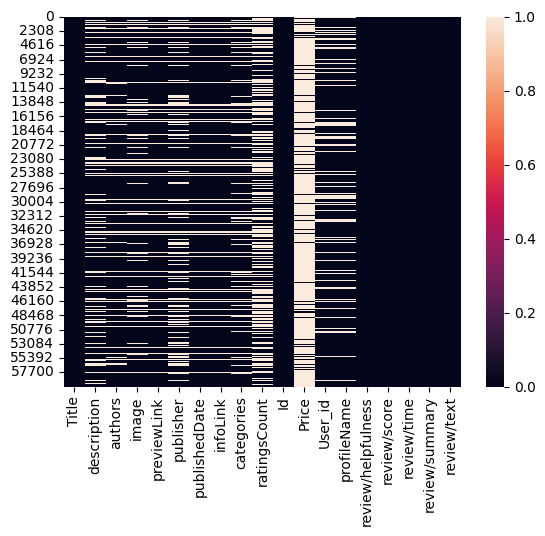

                                      Title  \
0                            Atlas Shrugged   
1                The Republic (Non Fiction)   
2                            The ice people   
3              Portuguese Homestyle Cooking   
4  Stone Dead (Worldwide Library Mysteries)   

                                         description                  authors  \
0                                                NaN                      NaN   
1  A New York Times bestseller The author of the ...          ['Azar Nafisi']   
2  It's the middle of the twenty-first century, a...           ['Maggie Gee']   
3  Authentic recipes that unlock the mysteries of...  ['Ana Patuleia Ortins']   
4  Detective Chief Inspector Neil Paget and his a...          ['Frank Smith']   

                                               image  \
0                                                NaN   
1  http://books.google.com/books/content?id=8jNBA...   
2  http://books.google.com/books/content?id=JjYhB...   
3  htt

<ipython-input-13-d05756afc218>:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = self.books_df.corr()


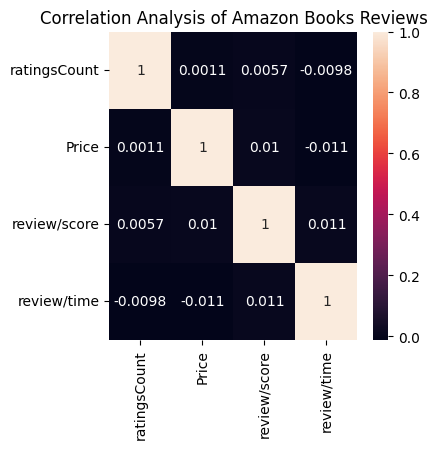

In [15]:
eda.explore()

In [16]:
eda.data_cleaning()

New dataset shape:
 (59995, 19)
Removing irrevelant variables...

New dataset columns:\ Index(['Title', 'description', 'authors', 'image', 'publisher',
       'publishedDate', 'categories', 'ratingsCount', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


In [ ]:
eda.univariate_variables()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59995 entries, 0 to 59994
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               59987 non-null  object
 1   description         47110 non-null  object
 2   authors             52061 non-null  object
 3   image               49191 non-null  object
 4   publisher           44259 non-null  object
 5   publishedDate       52767 non-null  object
 6   categories          48813 non-null  object
 7   review/helpfulness  59995 non-null  object
 8   review/summary      59993 non-null  object
 9   review/text         59995 non-null  object
dtypes: object(10)
memory usage: 4.6+ MB
Categorical and textual features:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59995 entries, 0 to 59994
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ratingsCount  32440 non-null  float

<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 31168 (\N{CJK UNIFIED IDEOGRAPH-79C0}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from current font.
  plt.tight_layout()
<ipython-input-13-d05756afc218>:66: Us

In [ ]:
len(books_df)

In [ ]:
%cd {base_path}final_project
!git config --global --unset credential.helper
#!git config --global user.name "fernandaluft"
#!git config --global user.email "fernandaluft@gmail.com"
#!git config --global user.name "neural1977"
#!git config --global user.email "pugliese05@gmail.com"
!git add .
!git commit -m "New Final Project"


In [ ]:
!git push origin main